In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

from pprint import pprint
from rouge import Rouge

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.layers import LSTM, Input, TimeDistributed, Dense, Activation, RepeatVector, Embedding, Bidirectional, Concatenate
from keras.optimizers import Adam, Nadam
from keras.losses import sparse_categorical_crossentropy, KLDivergence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.utils import plot_model

import matplotlib.pyplot as plt 
from keras.regularizers import l2
import os

Using TensorFlow backend.


In [2]:
df = pd.read_csv('../data/wikihowAll_cleaned.csv', delimiter=',', nrows=180000)

In [3]:
df.head()

,headline,text
0,keep related supplies in the same area make an...,photographer keep necessary lens cord battery ...
1,create a sketch in the neopoprealist manner of...,see image draw develops stepbystep however imp...
2,get a bachelors degree enroll in a studiobased...,possible become vfx artist without college deg...
3,start with some experience or interest in art ...,best art investor research piece art buy someo...
4,keep your reference materials sketches article...,start planning project work shall likely gathe...


In [4]:
df['headline'] = df['headline'].apply(lambda x : '_SOS_ '+ x + ' _EOS_')

In [5]:
df.head()

,headline,text
0,_SOS_ keep related supplies in the same area m...,photographer keep necessary lens cord battery ...
1,_SOS_ create a sketch in the neopoprealist man...,see image draw develops stepbystep however imp...
2,_SOS_ get a bachelors degree enroll in a studi...,possible become vfx artist without college deg...
3,_SOS_ start with some experience or interest i...,best art investor research piece art buy someo...
4,_SOS_ keep your reference materials sketches a...,start planning project work shall likely gathe...


In [10]:
count = 0
for i in df['text'].astype(str).values.tolist():
    if(len(i.split())<=80):
        count += 1
print(count/len(df['text'].astype(str).values.tolist()))

0.2665983360150251


74% тексту менші за 350

In [9]:
count = 0
for i in df['headline'].astype(str).values.tolist():
    if(len(i.split())<=20):
        count += 1
print(count/len(df['headline'].astype(str).values.tolist()))

0.14114669522048087


Розділимо датасет на тренувальний, тестувальний і валідаційний

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
train, test = train_test_split(df, test_size=0.05, random_state=42, shuffle=True)

In [13]:
train, val = train_test_split(train, test_size=0.056, random_state=42, shuffle=True)

In [14]:
train.shape

(156617, 2)

In [15]:
test.shape

(8733, 2)

In [16]:
val.shape

(9291, 2)

In [17]:
max_len_text = 80 
max_len_summary = 20

In [18]:
X_train = train['text'].astype(str).values.tolist()
X_test = test['text'].astype(str).values.tolist()
X_val = val['text'].astype(str).values.tolist()

Y_train = train['headline'].astype(str).values.tolist()
Y_test = test['headline'].astype(str).values.tolist()
Y_val = val['headline'].astype(str).values.tolist()

Keras padding https://keras.io/guides/understanding_masking_and_padding/

In [19]:
x_vocab = 25000

x_tokenizer = Tokenizer(num_words=x_vocab)
x_tokenizer.fit_on_texts(X_train)

x_train = x_tokenizer.texts_to_sequences(X_train)
x_val = x_tokenizer.texts_to_sequences(X_val)

x_train = pad_sequences(x_train, maxlen=max_len_text, padding="post")
x_val = pad_sequences(x_val, maxlen=max_len_text, padding="post")

y_vocab = 10000

y_tokenizer = Tokenizer(num_words=y_vocab)
y_tokenizer.fit_on_texts(Y_train)

y_train= y_tokenizer.texts_to_sequences(Y_train)
y_val = y_tokenizer.texts_to_sequences(Y_val)

y_train = pad_sequences(y_train, maxlen=max_len_summary, padding="post")
y_val = pad_sequences(y_val, maxlen=max_len_summary, padding="post")

In [20]:
y_vocab

10000

In [21]:
x_vocab

25000

In [29]:
batch_size = 512
epochs = 15
latent_dim = 400
embedding_dim = 100

In [23]:
embeddings_index = {}
f = open(os.path.join("/home/maksboruh/course/text-summarization/program/", 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [24]:
x_word_index = x_tokenizer.word_index
x_embedding_matrix = np.zeros((x_vocab, embedding_dim))
for word, i in x_word_index.items():
    if (i >= x_vocab):
        break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        x_embedding_matrix[i] = embedding_vector

In [25]:
y_word_index = y_tokenizer.word_index
y_embedding_matrix = np.zeros((y_vocab, embedding_dim))
for word, i in y_word_index.items():
    if (i >= y_vocab):
        break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        y_embedding_matrix[i] = embedding_vector

In [26]:
# Encoder 
encoder_inputs = Input(shape=(max_len_text,), name="encoder_in") 
# enc_emb_layer = Embedding(x_vocab, embedding_dim, mask_zero=True, name="encoder_emb")

enc_emb_layer = Embedding(x_vocab, embedding_dim, weights=[x_embedding_matrix], 
                            input_length=max_len_text, trainable=False, name="encoder_emb")
enc_emb = enc_emb_layer(encoder_inputs) 

# LSTM


#LSTM 1 
# encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True,
#                     dropout=0.4, recurrent_dropout=0.2, name="encoder_first_lstm") 
# encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm = LSTM(latent_dim, return_state=True, name="encoder_first_lstm", 
                    dropout=0.4, recurrent_dropout=0.2) 
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb) 
encoder_states = [state_h, state_c]

# Decoder 
decoder_inputs = Input(shape=(None,), name="decoder_in") 
# dec_emb_layer = Embedding(y_vocab, embedding_dim, mask_zero=True, name="decoder_emb")
dec_emb_layer = Embedding(y_vocab, embedding_dim, weights=[y_embedding_matrix], 
                            trainable=False, name="decoder_emb")
dec_emb = dec_emb_layer(decoder_inputs) 


#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name="decoder_first_lstm") 
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states) 

#Dense layer
decoder_dense = Dense(y_vocab, activation='softmax', name="decoder_dense") 
decoder_outputs = decoder_dense(decoder_outputs) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_in (InputLayer)         (None, 80)           0                                            
__________________________________________________________________________________________________
decoder_in (InputLayer)         (None, None)         0                                            
__________________________________________________________________________________________________
encoder_emb (Embedding)         (None, 80, 100)      2500000     encoder_in[0][0]                 
__________________________________________________________________________________________________
decoder_emb (Embedding)         (None, None, 100)    1000000     decoder_in[0][0]                 
____________________________________________________________________________________________

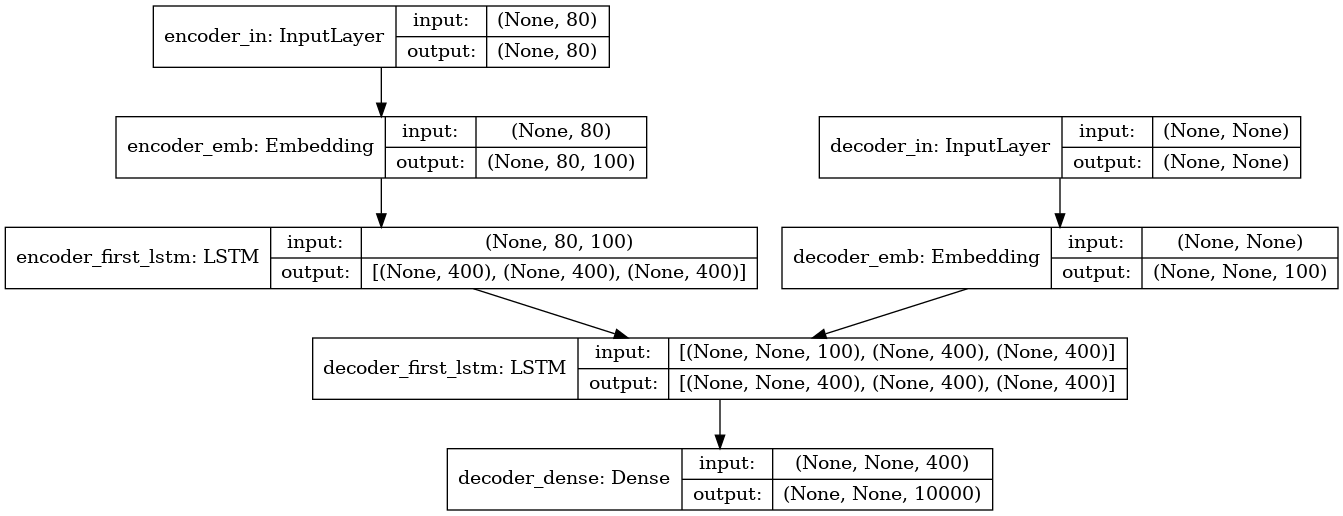

In [27]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [30]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [31]:
es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience=1)

In [32]:
history=model.fit([x_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:],
                  epochs=epochs,
                  callbacks=[es],
                  batch_size=batch_size, 
                  validation_data=([x_val, y_val[:,:-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]))

Train on 156617 samples, validate on 9291 samples
Epoch 1/15
156617/156617 [==============================] - 811s 5ms/step - loss: 5.9518 - val_loss: 5.4439
Epoch 2/15
156617/156617 [==============================] - 810s 5ms/step - loss: 5.1790 - val_loss: 4.9641
Epoch 3/15
156617/156617 [==============================] - 809s 5ms/step - loss: 4.8327 - val_loss: 4.7437
Epoch 4/15
156617/156617 [==============================] - 810s 5ms/step - loss: 4.6160 - val_loss: 4.5812
Epoch 5/15
156617/156617 [==============================] - 810s 5ms/step - loss: 4.4623 - val_loss: 4.4467
Epoch 6/15
156617/156617 [==============================] - 810s 5ms/step - loss: 4.3465 - val_loss: 4.4353
Epoch 7/15
156617/156617 [==============================] - 810s 5ms/step - loss: 4.2548 - val_loss: 4.3159
Epoch 8/15
156617/156617 [==============================] - 810s 5ms/step - loss: 4.1804 - val_loss: 4.2667
Epoch 9/15
156617/156617 [==============================] - 811s 5ms/step - loss: 4.11

In [34]:
model.save("seq2seq_180000.h5")

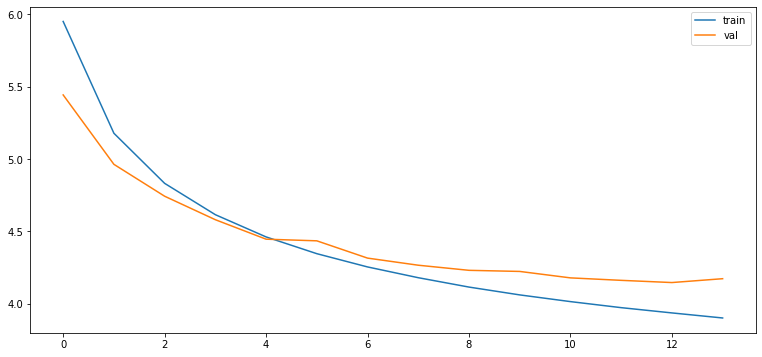

In [35]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='val') 
pyplot.legend() 
pyplot.show()

In [36]:
reverse_target_word_index = y_tokenizer.index_word 
reverse_source_word_index = x_tokenizer.index_word 
target_word_index = y_tokenizer.word_index

In [37]:
model = load_model("seq2seq_180000.h5")

In [38]:
model

In [39]:
model.input

[<tf.Tensor 'encoder_in_1:0' shape=(None, 80) dtype=float32>,
 <tf.Tensor 'decoder_in_1:0' shape=(None, None) dtype=float32>]

In [40]:
model.layers

In [41]:
model.layers[4].output[1]

<tf.Tensor 'encoder_first_lstm_1/while:4' shape=(None, 400) dtype=float32>

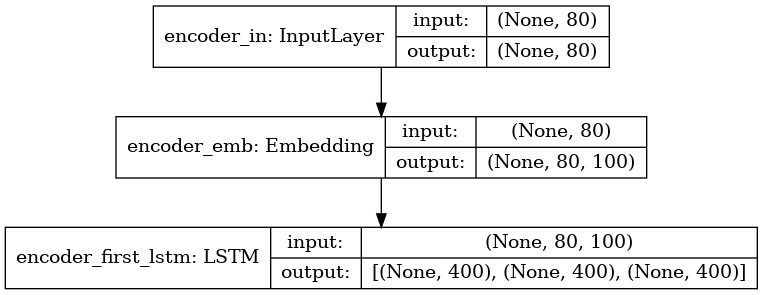

In [42]:
# encoder inference
encoder_inputs = model.input[0]

encoder_embedding_layer = model.layers[2]
encoder_embedding = encoder_embedding_layer(encoder_inputs)

encoder_outputs, state_h_enc, state_c_enc = model.layers[4](encoder_embedding) #last lstm layer
encoder_states = [state_h_enc, state_c_enc]

encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_model_plot.png', show_shapes=True, show_layer_names=True)

In [43]:
model.input[1]

<tf.Tensor 'decoder_in_1:0' shape=(None, None) dtype=float32>

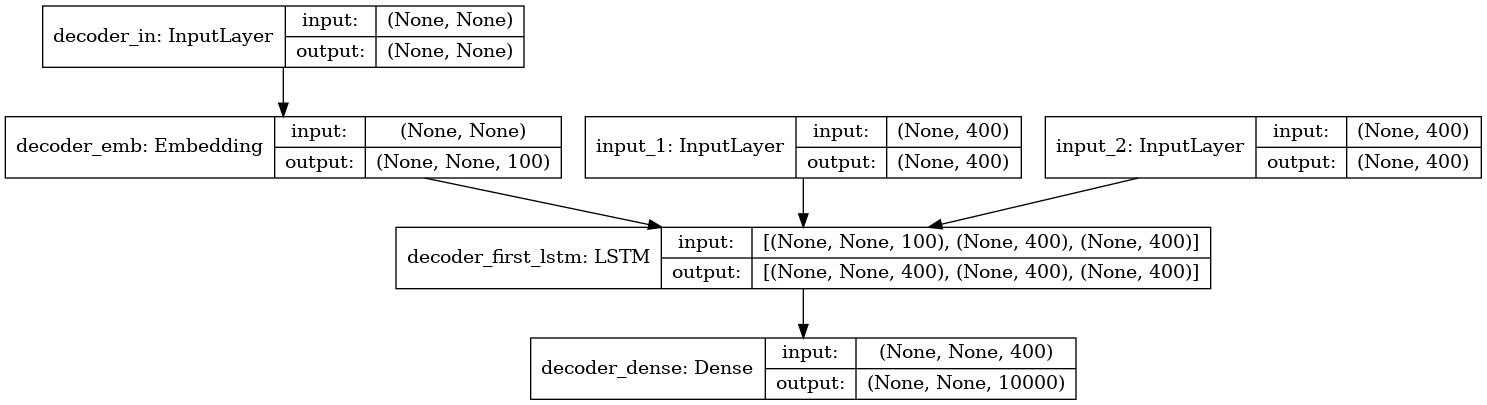

In [44]:
# decoder inference
decoder_inputs = model.input[1]
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_embedding_layer = model.layers[3]
decoder_embedding = decoder_embedding_layer(decoder_inputs)

decoder_lstm = model.layers[5]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
decoder_states = [state_h_dec, state_c_dec]

decoder_dense = model.layers[6]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_model_plot.png', show_shapes=True, show_layer_names=True)

Choosing next word https://arxiv.org/pdf/1904.09751.pdf

In [45]:
def softmax(x):
    return np.exp(x)/sum(np.exp(x))

In [46]:
def n_max_elements(data, n):
    elems = []
    indexs = []
  
    for i in range(0, n): 
        max_ = 0
        index = 0
          
        for j in range(len(data)):     
            if data[j] > max_ and data[j] not in elems:
                max_ = data[j];
                index = j
                  
        elems.append(max_)
        indexs.append(index)
          
    return elems, indexs

In [47]:
def close_to_num(data, num):
    elem = 0
    index = 0
 
    for j in range(len(data)):     
        if data[j] > elem and data[j] < num:
            elem = data[j];
            index = j
          
    return elem, index

In [48]:
def top_k_sampling(data, k):
    pred = data[0]
    top_k_prob, top_k_index = n_max_elements(pred, k)
    top_k_prob_soft = softmax(np.log(top_k_prob))
    sampled_token = np.random.choice(top_k_index, p=top_k_prob_soft)
    return sampled_token

In [49]:
def nucleus_sampling(data, p):
    pred = data[0]
    sum_ = 0
    top_k_prob = []
    top_k_index = []
    prob = 1
    while sum_ <= p:
        prob, index = close_to_num(pred, prob)
        top_k_prob.append(prob)
        top_k_index.append(index)
        sum_ += prob
    top_k_prob_soft = softmax(np.log(top_k_prob))
    sampled_token = np.random.choice(top_k_index, p=top_k_prob_soft)
    return sampled_token

In [50]:
def beam_search_decoder(data, k=1):
    sequences = [[list(), 0.0]]
    
    for row in data:
        all_candidates = list()
        # expand each current candidate
        for i in range(len(sequences)):
            seq, score = sequences[i]
            for j in range(len(row)):
                candidate = [seq + [j], score - np.log(row[j])]
                all_candidates.append(candidate)
        # order all candidates by score
        ordered = sorted(all_candidates, key=lambda tup:tup[1])
        # select k best
        sequences = ordered[:k]
    return sequences

In [52]:
def decode_sequence(input_seq):
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['sos']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        # Sample a token
#         sampled_token_index = np.argmax(output_tokens[0, -1, :])
#         sampled_token_index = np.random.choice(len(output_tokens[0, -1, :]), p=output_tokens[0, -1, :]    
#         sampled_token_index = beam_search_decoder(output_tokens[0, -1:], 2)[1][0][0]
        sampled_token_index = top_k_sampling(output_tokens[0, -1:], 10)
#         sampled_token_index = nucleus_sampling(output_tokens[0, -1:], 0.25)
        
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eos':
            decoded_sentence += ' ' + sampled_token

            # Exit condition: either hit max length or find stop word.
        if sampled_token == 'eos' or len(decoded_sentence.split()) > max_len_summary:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        states_value = [h, c]

    return decoded_sentence

In [53]:
def seq2summary(input_seq):
    summary=''
    for i in input_seq:
        if (i != 0 and i != target_word_index['sos']) and i != target_word_index['eos']:
            summary += reverse_target_word_index[i]+' '           
    return summary

def seq2text(input_seq):
    return x_tokenizer.sequences_to_texts([input_seq])[0]

In [58]:
i=13
print("Review:", seq2text(x_val[i]))
print("\nOriginal summary:", seq2summary(y_val[i]))
print("\nPredicted summary:", decode_sequence(x_val[i].reshape(1, max_len_text)))
print("\n\n")

print("Review:", seq2text(x_train[i]))
print("\nOriginal summary:", seq2summary(y_train[i]))
print("\nPredicted summary:", decode_sequence(x_train[i].reshape(1, max_len_text)))
print("\n\n")

Review: make wand fun example harry potter fan stop like wand do want create friendship token wish incorporate wand religious ceremony may wish add item carry significant meaning include crystal bunch mixed herb type magical stone use item rub wand could also attach desire make friendship token good idea look meaning wood herb reflect nature friendship meaning plant material use might also want paint stain number color use may possible carve design wood well take great deal skill patience undertaken lightly

Original summary: additions to your wand if you wish also be sure to use sandpaper to make your wand smooth finished 

Predicted summary:  get a list of paper decorate the tree place them have it grow



Review: make sure store fridge use week add essential oil whatever quantity like achieve nice scent consistency peel one two orange one two lemon allow peel sit boil water overnight add vitamin e oil two capsule mixture shake sure strain water citrus peel leave soak overnight use r

In [55]:
i=5
print("Review:", seq2text(x_val[i]))
print("\nOriginal summary:", seq2summary(y_val[i]))
print("\nPredicted summary:", decode_sequence(x_val[i].reshape(1, max_len_text)))
print("\n\n")

print("Review:", seq2text(x_train[i]))
print("\nOriginal summary:", seq2summary(y_train[i]))
print("\nPredicted summary:", decode_sequence(x_train[i].reshape(1, max_len_text)))
print("\n\n")

Review: can pot bring boil use pint boil jar minute use quart boil jar minute also keep mind cooking time vary base altitude can foot sea level minute pint minute quart foot minute pint minute quart foot minute pint minute quart foot minute pint minute quart allow pot cool minute remove jar lifter place jar towel allow jar cool whole day test seal jar push center center move use tomato immediately surprised see can tomato float layer liquid inside totally normal

Original summary: canning pot and turn off the heat store sealed jars in a cool pantry and use within one year 

Predicted summary:  combine the ingredients in a bowl cover the jars and refrigerate overnight remove the jars



Review: keep gathering hair hair line add bottom strand gather hair let add top strand reach side head gather hair part add top headband tie add braiding upward step time try bending forward head point towards ground back start hair left dutch braid switch regular braid tie clear hair elastic time wrap b

Виродження тексту
https://dasha.ai/en-us/blog/neural-text-degeneration
https://stackoverflow.com/questions/46924452/what-to-do-when-seq2seq-network-repeats-words-over-and-over-in-output

In [183]:
states_value = encoder_model.predict(x_val[i].reshape(1, max_len_text))
                                     

target_seq = np.zeros((1, 1))

# Chose the 'start' word as the first word of the target sequence
target_seq[0, 0] = target_word_index['sos']

decoded_sentence = ''
output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
   
# sampled_token_index = beam_search_decoder(output_tokens[0, -1:], 2)[1][0][0]
sampled_token_index = top_k_sampling(output_tokens[0, -1:], 3)


sampled_token = reverse_target_word_index[sampled_token_index]

In [184]:
sampled_token

'wear'

In [148]:
len(output_tokens[0,-1:][0])

5264

In [46]:
assert(False)

AssertionError: 

Keras doc
https://keras.io/guides/working_with_rnns/

In [ ]:
encoder_lstm = LSTM(latent_dim, return_state=True, name="encoder_first_lstm", 
                    dropout=0.4, recurrent_dropout=0.2) 
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

LSTM cell http://colah.github.io/posts/2015-08-Understanding-LSTMs/

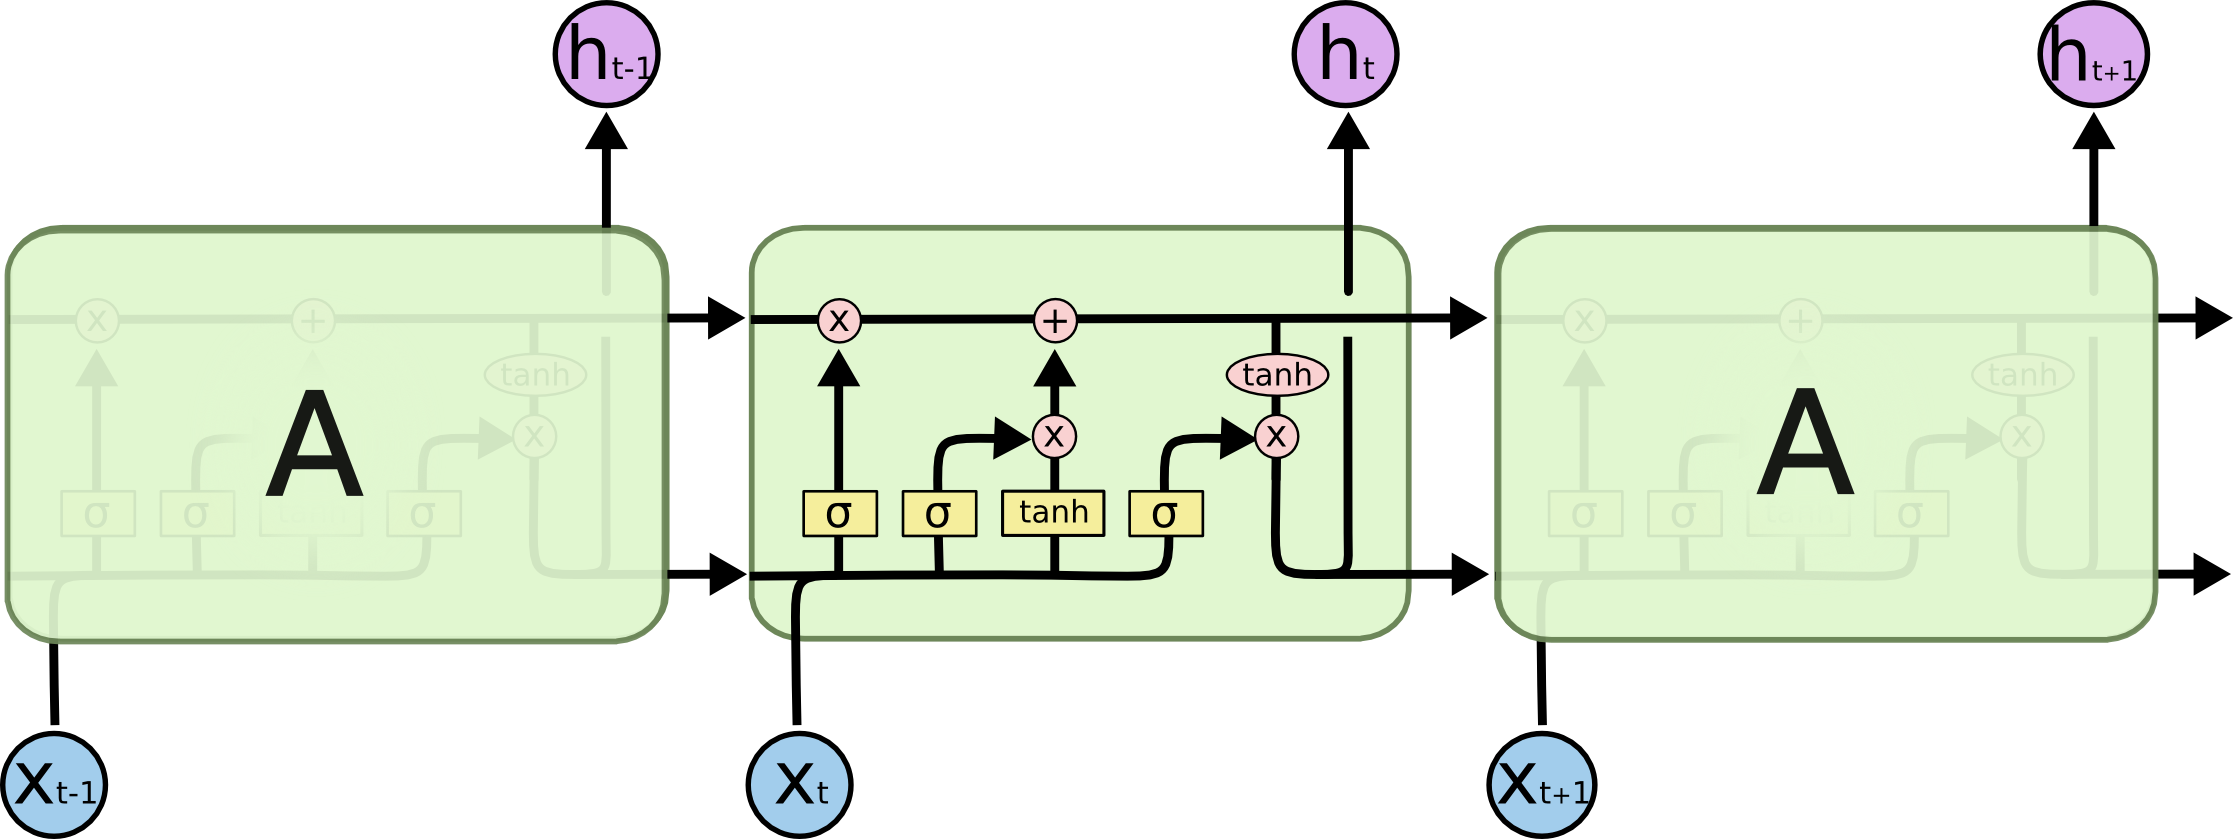

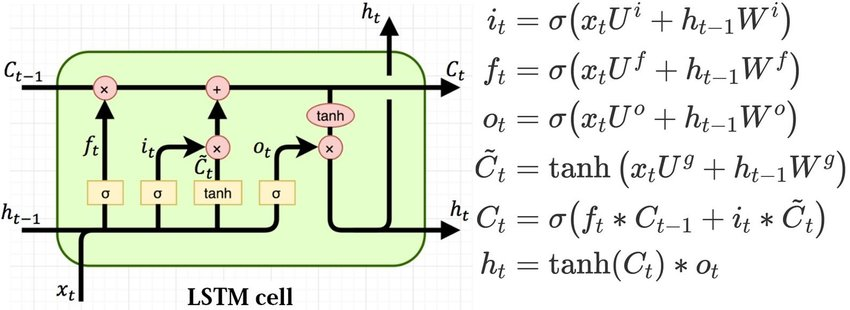

Custom keras layer https://keras.io/guides/making_new_layers_and_models_via_subclassing/

In [22]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [23]:
class LSTM_custom():
    def __init__(self, hidden_units, vocab_size, h_prev=None, c_prev=None):
        self.hidden_units = hidden_units
        self.vocab_size = vocab_size
        self.input_units = self.vocab_size + self.hidden_units
        
        self.h_prev = h_prev      
        self.c_prev = c_prev
        self.h = []
        self.c = []
        
        self.f_t = []
        self.i_t = []
        self.c_t = []
        self.o_t = []
        self.v_t = []
        self.output_t = []
        
        self.x = []
        
        self.initialize_parameters()
        
    def initialize_parameters(self):
        mean = 0
        std = 0.01

        self.W_f = np.random.normal(mean, std, (self.hidden_units, self.input_units))
        self.W_i = np.random.normal(mean, std, (self.hidden_units, self.input_units))
        self.W_o = np.random.normal(mean, std, (self.hidden_units, self.input_units))
        self.W_c = np.random.normal(mean, std, (self.hidden_units, self.input_units))
        self.W_v = np.random.normal(mean, std, (self.vocab_size, self.hidden_units))
        
        self.b_f = np.random.normal(mean, std, (self.hidden_units, 1))
        self.b_i = np.random.normal(mean, std, (self.hidden_units, 1))
        self.b_o = np.random.normal(mean, std, (self.hidden_units, 1))
        self.b_c = np.random.normal(mean, std, (self.hidden_units, 1))
        self.b_v = np.random.normal(mean, std, (self.vocab_size, 1))
        
        if self.c_prev is None: 
            self.c.append( np.zeros((self.hidden_units, 1)) )
        if self.h_prev is None: 
            self.h.append( np.zeros((self.hidden_units, 1)) ) 
            
            
    def forget_gate(self):         
        self.f_t.append( sigmoid( np.dot(self.W_f, np.row_stack((self.h[-1], self.x[-1]))) + self.b_f ) )
    
    def input_gate(self):
        self.i_t.append( sigmoid( np.dot(self.W_i, np.row_stack((self.h[-1], self.x[-1]))) + self.b_i ) )
        self.c_t.append( np.tanh( np.dot(self.W_c, np.row_stack((self.h[-1], self.x[-1]))) + self.b_c ) )
        
    def drop_gate(self):
        self.c.append( self.f_t[-1]*self.c[-1] + self.i_t[-1]*self.c_t[-1] )
    
    def output_gate(self):
        self.o_t.append( sigmoid( np.dot(self.W_o, np.row_stack((self.h[-1], self.x[-1]))) + self.b_o ) )
        self.h.append( self.o_t[-1] * np.tanh( self.c[-1] ) )     
        
    def logits(self):
        self.v_t.append( np.dot(self.W_v, self.h[-1]) + self.b_v )
    
    def soft(self):
        self.output_t.append( softmax(self.v_t[-1]) )
    
    def forward(self, inputs):
        
        for el in inputs:
            self.x.append(el)
            self.forget_gate()
            self.input_gate()
            self.drop_gate()
            self.output_gate()
            self.logits()
            self.soft()
    
    def backward(outputs, targets):

        W_f_d = np.zeros_like(self.W_f)
        b_f_d = np.zeros_like(self.b_f)

        W_i_d = np.zeros_like(self.W_i)
        b_i_d = np.zeros_like(self.b_i)

        W_c_d = np.zeros_like(self.W_c)
        b_c_d = np.zeros_like(self.b_c)

        W_o_d = np.zeros_like(self.W_o)
        b_o_d = np.zeros_like(self.b_o)

        W_v_d = np.zeros_like(self.W_v)
        b_v_d = np.zeros_like(self.b_v)

        dh_next = np.zeros_like(self.h[0])
        dC_next = np.zeros_like(self.c[0])

        loss = 0

        for t in reversed(range(len(self.output_t))):

            # Compute the cross entropy
            loss += -np.mean(np.log(self.output_t[t]) * targets[t])
            # Get the previous hidden cell state
            c_prev= self.c[t-1]

            # Compute the derivative of the relation of the hidden-state to the output gate
            dv = np.copy(self.output_t[t])
            dv[np.argmax(targets[t])] -= 1

            # Update the gradient of the relation of the hidden-state to the output gate
            W_v_d += np.dot(dv, self.h[t].T)
            b_v_d += dv

            # Compute the derivative of the hidden state and output gate
            dh = np.dot(self.W_v.T, dv)        
            dh += dh_next
            do = dh * tanh(self.c[t])
            do = sigmoid(self.o_t[t], derivative=True)*do

            # Update the gradients with respect to the output gate
            W_o_d += np.dot(do, np.row_stack((self.h[t], self.x[t])).T)
            b_o_d += do

            # Compute the derivative of the cell state and candidate g
            dC = np.copy(dC_next)
            dC += dh * self.o_t[t] * np.tanh(np.tanh(self.c[t]), derivative=True)
            dg = dC * self.i_t[t]
            dg = tanh(g[t], derivative=True) * dg

            # Update the gradients with respect to the candidate
            W_g_d += np.dot(dg, np.row_stack((self.h[t], self.x[t])).T)
            b_g_d += dg

            # Compute the derivative of the input gate and update its gradients
            di = dC * g[t]
            di = sigmoid(self.i_t[t], True) * di
            W_i_d += np.dot(di, np.row_stack((self.h[t], self.x[t])).T)
            b_i_d += di

            # Compute the derivative of the forget gate and update its gradients
            df = dC * c_prev
            df = sigmoid(self.f_t[t]) * df
            W_f_d += np.dot(df, np.row_stack((self.h[t], self.x[t])).T)
            b_f_d += df

            # Compute the derivative of the input and update the gradients of the previous hidden and cell state
            dz = (np.dot(self.W_f.T, df)
                 + np.dot(self.W_i.T, di)
                 + np.dot(self.W_c.T, dg)
                 + np.dot(self.W_o.T, do))
            dh_prev = dz[:hidden_size, :]
            dC_prev = self.f_t[t] * dC

        grads= W_f_d, W_i_d, W_g_d, W_o_d, W_v_d, b_f_d, b_i_d, b_g_d, b_o_d, b_v_d

        # Clip gradients
        grads = self.clip_gradient_norm(grads)

        return loss, grads
    
    def clip_gradient_norm(self, grads, max_norm=0.25):
        """
        Clips gradients to have a maximum norm of `max_norm`.
        This is to prevent the exploding gradients problem.
        """ 
        # Set the maximum of the norm to be of type float
        max_norm = float(max_norm)
        total_norm = 0

        # Calculate the L2 norm squared for each gradient and add them to the total norm
        for grad in grads:
            grad_norm = np.sum(np.power(grad, 2))
            total_norm += grad_norm

        total_norm = np.sqrt(total_norm)

        # Calculate clipping coeficient
        clip_coef = max_norm / (total_norm + 1e-6)

        # If the total norm is larger than the maximum allowable norm, then clip the gradient
        if clip_coef < 1:
            for grad in grads:
                grad *= clip_coef

        return grads


    def update_parameters(self, params, grads, lr=1e-3):
        # Take a step
        for param, grad in zip(params, grads):
            param -= lr * grad

        return params

In [746]:
num_epochs = 10

lstm = LSTM_custom(hidden_size=hidden_size, vocab_size=vocab_size)

# Initialize hidden state as zeros
hidden_state = np.zeros((hidden_size, 1))

# Track loss
training_loss, validation_loss = [], []

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    # For each sentence in validation set
    for inputs, targets in validation_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

        # Initialize hidden state and cell state as zeros
#         h = np.zeros((hidden_size, 1))
#         c = np.zeros((hidden_size, 1))

        # Forward pass
        lstm.forward(inputs_one_hot)
        
        # Backward pass
        loss, _ = lstm.backward(outputs, targets_one_hot)
        
        # Update loss
        epoch_validation_loss += loss
    
    # For each sentence in training set
    for inputs, targets in training_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

        # Initialize hidden state and cell state as zeros
#         h = np.zeros((hidden_size, 1))
#         c = np.zeros((hidden_size, 1))

        # Forward pass
        lstm.forward(inputs_one_hot, h, c)
        
        # Backward pass
        loss, grads = lstm.backward(outputs, targets_one_hot)
        
        # Update parameters
        params = update_parameters(params, grads, lr=1e-1)
        
        # Update loss
        epoch_training_loss += loss
                
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))

    # Print loss every 10 epochs
    if i % 10 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')

    
# Get first sentence in test set
inputs, targets = test_set[1]

# One-hot encode input and target sequence
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

# Initialize hidden state as zeros
h = np.zeros((hidden_size, 1))
c = np.zeros((hidden_size, 1))

# Forward pass
z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs_one_hot, h, c, params)

# Print example
print('Input sentence:')
print(inputs)

print('\nTarget sequence:')
print(targets)

print('\nPredicted sequence:')
print([idx_to_word[np.argmax(output)] for output in outputs])

# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

NameError: name 'hidden_size' is not defined

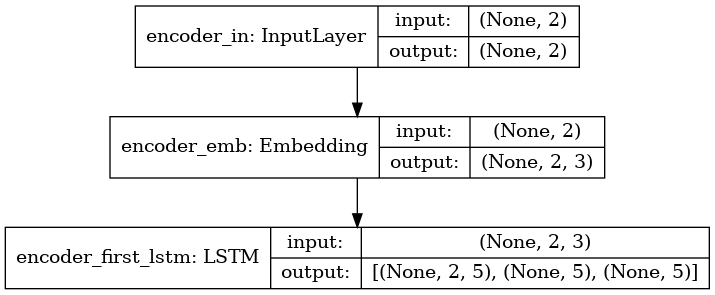

In [601]:
# encoder inference
encoder_inputs_2 = Input(shape=(2,), name="encoder_in") 

encoder_embedding_layer_2 = Embedding(2, 3, 
                            input_length=2, name="encoder_emb")
encoder_embedding_2 = encoder_embedding_layer_2(encoder_inputs_2)

encoder_outputs_2, state_h_enc_2, state_c_enc_2 = LSTM(5, return_state=True, return_sequences=True,
                                                 name="encoder_first_lstm") (encoder_embedding_2) 
# encoder_states_2 = [state_h_enc_2, state_c_enc_2]

encoder_model_2 = Model(encoder_inputs_2, [encoder_outputs_2, state_h_enc_2, state_c_enc_2])

plot_model(encoder_model_2, to_file='encoder_model_plot_2.png', show_shapes=True, show_layer_names=True)

In [596]:
inp = np.array([1, 1]).reshape(1, 2)

In [646]:
inp.shape[1]

2

In [598]:
emb_2 = encoder_model_2.predict(inp)

In [599]:
emb = emb_2

In [778]:
emb_2

array([[[-0.03834592, -0.02668532, -0.03902818],
        [-0.03834592, -0.02668532, -0.03902818]]], dtype=float32)

In [602]:
lst, h_, c_ = encoder_model_2.predict(inp)

In [737]:
# lst[0]

In [738]:
# h_[0]

In [739]:
# c_[0]

In [647]:
emb = emb.reshape(inp.shape[1], 3, inp.shape[0])

In [740]:
# emb

In [732]:
ll = LSTM_custom(5, 3)

In [733]:
z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = ll.forward(emb)

In [741]:
# len(h_s)

In [742]:
# h_s

In [743]:
# C_s

Initialize Parameters
Embeddings Size = 100
Hidden Units = 256
Total INPUT Weights = 100 + 256 = 356

LSTM CELL Weights

Forget Gate Weights = {356,256}
Input Gate Weights = {356,256}
Gate Gate Weights = {356,256}
Output Gate Weights = {356,256}

Output CELL Weights

Output Weights = {256,27}

In [38]:
from keras import layers

In [39]:
class LSTM_cell(layers.Layer):
    def __init__(self, initializer="he_normal", **kwargs):
        super(Antirectifier, self).__init__(**kwargs)
        self.initializer = keras.initializers.get(initializer)

    def build(self, input_shape):
        output_dim = input_shape[-1]
        self.kernel = self.add_weight(
            shape=(output_dim * 2, output_dim),
            initializer=self.initializer,
            name="kernel",
            trainable=True,
        )

    def call(self, inputs):
        inputs -= tf.reduce_mean(inputs, axis=-1, keepdims=True)
        pos = tf.nn.relu(inputs)
        neg = tf.nn.relu(-inputs)
        concatenated = tf.concat([pos, neg], axis=-1)
        mixed = tf.matmul(concatenated, self.kernel)
        return mixed

    def get_config(self):
        # Implement get_config to enable serialization. This is optional.
        base_config = super(Antirectifier, self).get_config()
        config = {"initializer": keras.initializers.serialize(self.initializer)}
        return dict(list(base_config.items()) + list(config.items()))

In [40]:
batch_size = 128
num_classes = 10
epochs = 20

# The data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# Build the model
model = keras.Sequential(
    [
        keras.Input(shape=(784,)),
        layers.Dense(256),
        Antirectifier(),
        layers.Dense(256),
        Antirectifier(),
        layers.Dropout(0.5),
        layers.Dense(10),
    ]
)

# Compile the model
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Train the model
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.15)

# Test the model
model.evaluate(x_test, y_test)

60000 train samples
10000 test samples


TypeError: The added layer must be an instance of class Layer. Found: <keras.layers.core.Dense object at 0x7f246a1452e0>

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
antirectifier (Antirectifier (None, 256)               131072    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
antirectifier_1 (Antirectifi (None, 256)               131072    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 531,466
Trainable params: 531,466
Non-trainable params: 0
________________________________________________

In [36]:
plot_model(model, to_file='tests.png', show_shapes=True, show_layer_names=True)

TypeError: 'InputLayer' object is not iterable